In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
df_itens = pd.read_excel('../database/itens.xlsx')
df_trancacoes = pd.read_excel('../database/transacoes.xlsx')
df_item_transacoes = pd.read_excel('../database/itemtransacao.xlsx')

In [135]:
df_itens.head(10)

,codItem,descrição,marca,tipo
0,1,banana prata,banana,fruta
1,2,banana caturra,banana,fruta
2,3,limao Taiti,limao,fruta
3,4,limão siciliano,limão,fruta
4,5,coca,coca,refrigerante
5,6,coca light,coca,refrigerante
6,7,coca lemon light,coca,refirgerante
7,10,omo collors,omo,sabao em po
8,11,omo progress,omo,sabao em po
9,12,ariel total,ariel,sabao em po


In [136]:
df_trancacoes.head(10)

,IDTransação,valorTotal,tipo pagamento
0,1,15,ch
1,2,20,ch
2,3,14,es
3,4,19,ch
4,5,15,es
5,6,24,cc
6,7,16,ch
7,8,21,es
8,9,20,cc
9,10,17,cc


In [137]:
df_item_transacoes.head(10)

,IDTransação,item
0,1,1
1,1,4
2,1,12
3,2,12
4,3,2
5,3,12
6,5,2
7,5,5
8,6,1
9,6,3


In [138]:
df_merge = pd.merge(df_trancacoes, df_item_transacoes, on='IDTransação',how='inner')

In [139]:
replace_name_colunas = {'item':'codItem'}
df_merge.rename(columns=replace_name_colunas, inplace=True)

In [140]:
df_merge.head(10)

,IDTransação,valorTotal,tipo pagamento,codItem
0,1,15,ch,1
1,1,15,ch,4
2,1,15,ch,12
3,2,20,ch,12
4,3,14,es,2
5,3,14,es,12
6,5,15,es,2
7,5,15,es,5
8,6,24,cc,1
9,6,24,cc,3


In [141]:
df_final = pd.merge(df_itens, df_merge, on=['codItem'],how='inner')

In [142]:
df_final.replace('refirgerante', 'refrigerante', inplace=True)
df_final.replace('limao', 'limão', inplace=True)

## Gráficos

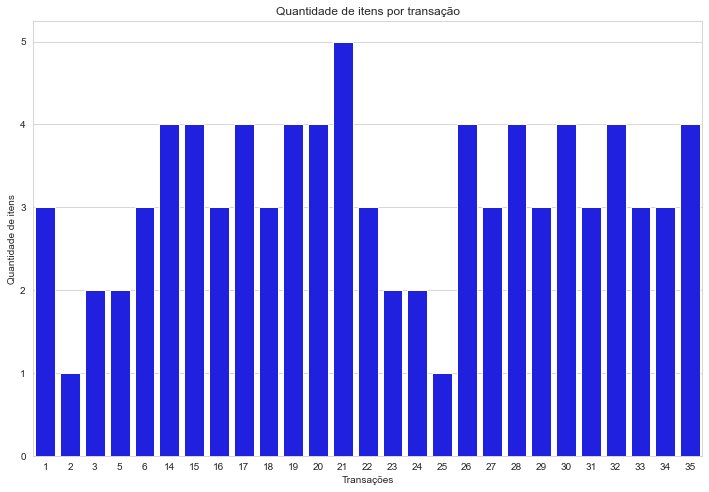

In [143]:
# Gráfico de barras horizontal - Quantidade de itens por transação
fig = plt.figure(figsize=(12,8))
sns.countplot(x='IDTransação', data=df_final, color='blue')
plt.title('Quantidade de itens por transação')
plt.xlabel('Transações')
plt.ylabel('Quantidade de itens')
plt.show()

In [144]:
df_final.groupby('IDTransação').size().describe()

count    27.000000
mean      3.148148
std       0.988538
min       1.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       5.000000
dtype: float64

In [145]:
df_final.groupby('IDTransação')['valorTotal'].sum().describe()

count     27.000000
mean      53.222222
std       26.889136
min       10.000000
25%       33.000000
50%       45.000000
75%       80.000000
max      120.000000
Name: valorTotal, dtype: float64

In [146]:
df_final.groupby('tipo')['valorTotal'].sum()*100/df_final.valorTotal.sum()

tipo
fruta           46.972860
refrigerante    26.235212
sabao em po     26.791928
Name: valorTotal, dtype: float64

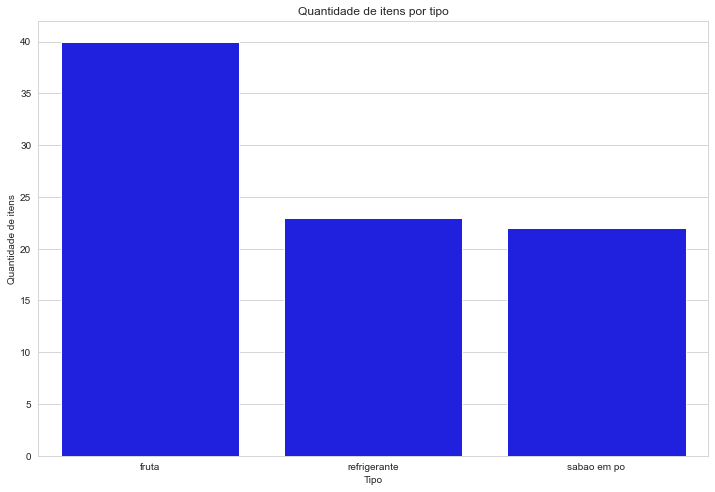

In [147]:
#Grafico de barra horizontal quantidade de itens por tipo
fig = plt.figure(figsize=(12,8))
sns.countplot(x='tipo', data=df_final, color='blue')
plt.title('Quantidade de itens por tipo')
plt.xlabel('Tipo')
plt.ylabel('Quantidade de itens')
plt.show()

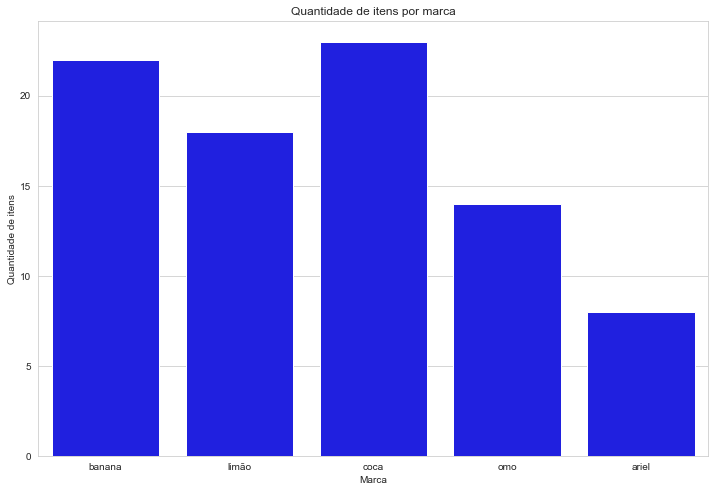

In [148]:
#Grafico de barra horizontal de quantidade de itens por marca
fig = plt.figure(figsize=(12,8))
sns.countplot(x='marca', data=df_final, color='blue')
plt.title('Quantidade de itens por marca')
plt.xlabel('Marca')
plt.ylabel('Quantidade de itens')
plt.show()

In [149]:
df_final.head()

,codItem,descrição,marca,tipo,IDTransação,valorTotal,tipo pagamento
0,1,banana prata,banana,fruta,1,15,ch
1,1,banana prata,banana,fruta,6,24,cc
2,1,banana prata,banana,fruta,14,10,es
3,1,banana prata,banana,fruta,15,20,cc
4,1,banana prata,banana,fruta,18,12,es


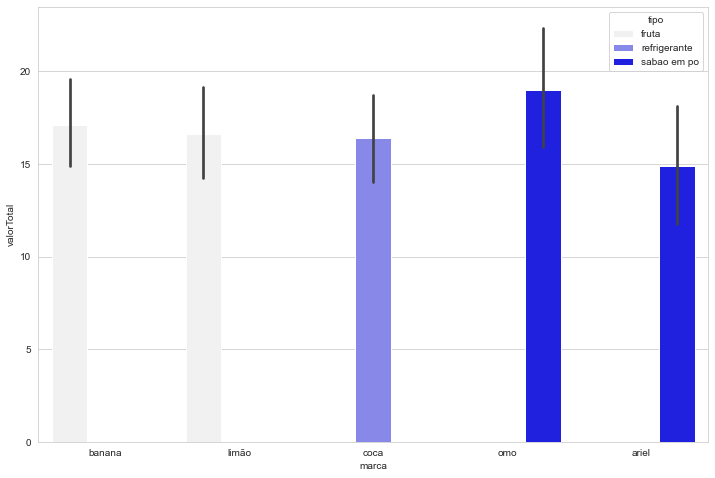

In [150]:
fig = plt.figure(figsize=(12,8))
sns.barplot(x='marca', y='valorTotal', data=df_final, color='blue', hue='tipo')
plt.show()

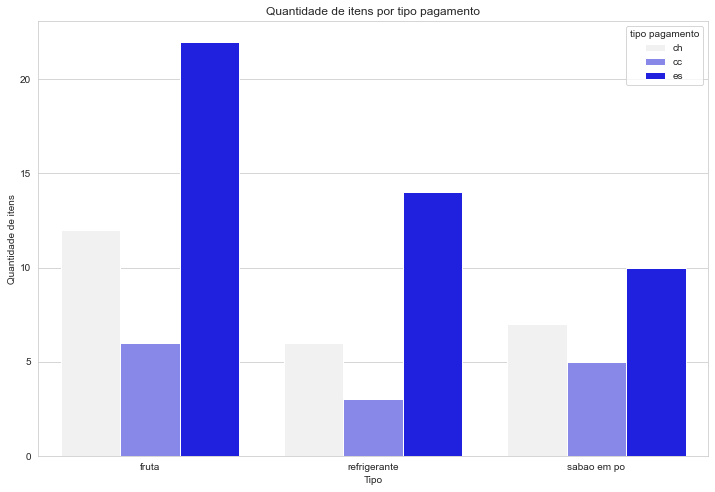

In [151]:
#pizza plot - quantidade de itens por tipo pagamento
fig = plt.figure(figsize=(12,8))
sns.countplot(x='tipo', data=df_final, color='blue', hue='tipo pagamento')
plt.title('Quantidade de itens por tipo pagamento')
plt.xlabel('Tipo')
plt.ylabel('Quantidade de itens')
plt.show()

## Apriori

In [152]:
data =df_final

In [153]:
data.head()

,codItem,descrição,marca,tipo,IDTransação,valorTotal,tipo pagamento
0,1,banana prata,banana,fruta,1,15,ch
1,1,banana prata,banana,fruta,6,24,cc
2,1,banana prata,banana,fruta,14,10,es
3,1,banana prata,banana,fruta,15,20,cc
4,1,banana prata,banana,fruta,18,12,es


In [154]:
from mlxtend.frequent_patterns import apriori, association_rules

#Eliminando espaços extras e transformando em minusculo
data['descrição'] = data['descrição'].str.strip()
data['descrição'] = data['descrição'].str.lower()
basket = data.groupby(['IDTransação', 'descrição'])['descrição'].count().unstack().reset_index().fillna(0).set_index('IDTransação')


In [155]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)

In [156]:
# Building the model
frq_items = apriori(basket_encoded, min_support = 0.05, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.head(20)

C:\Users\cassio.reis_saudeid\Desktop\CASSIO\SICRED\venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
171,"(omo collors, banana caturra)","(limao taiti, coca)",0.074074,0.074074,0.074074,1.0,13.500,0.068587,inf
174,"(limao taiti, coca)","(omo collors, banana caturra)",0.074074,0.074074,0.074074,1.0,13.500,0.068587,inf
199,"(limão siciliano, omo collors)","(banana prata, coca lemon light)",0.074074,0.074074,0.074074,1.0,13.500,0.068587,inf
202,"(banana prata, coca lemon light)","(limão siciliano, omo collors)",0.074074,0.074074,0.074074,1.0,13.500,0.068587,inf
170,"(omo collors, limao taiti)","(banana caturra, coca)",0.074074,0.111111,0.074074,1.0,9.000,0.065844,inf
172,"(omo collors, coca)","(limao taiti, banana caturra)",0.074074,0.148148,0.074074,1.0,6.750,0.063100,inf
184,"(limão siciliano, omo progress)","(coca light, banana caturra)",0.074074,0.148148,0.074074,1.0,6.750,0.063100,inf
188,"(omo progress, banana caturra)","(limão siciliano, coca light)",0.074074,0.148148,0.074074,1.0,6.750,0.063100,inf
200,"(limão siciliano, coca lemon light)","(banana prata, omo collors)",0.074074,0.148148,0.074074,1.0,6.750,0.063100,inf
212,"(banana prata, omo progress)","(coca light, limao taiti)",0.074074,0.148148,0.074074,1.0,6.750,0.063100,inf


### Marca

In [157]:
#Eliminando espaços extras e transformando em minusculo
basket = data.groupby(['IDTransação', 'marca'])['marca'].count().unstack().reset_index().fillna(0).set_index('IDTransação')

# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)

In [158]:
# Building the model
frq_items = apriori(basket_encoded, min_support = 0.05, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.head(20)

C:\Users\cassio.reis_saudeid\Desktop\CASSIO\SICRED\venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
34,"(banana, ariel, coca)",(limão),0.111111,0.666667,0.111111,1.000000,1.500000,0.037037,inf
6,(omo),(coca),0.518519,0.814815,0.518519,1.000000,1.227273,0.096022,inf
9,"(limão, ariel)",(banana),0.185185,0.814815,0.185185,1.000000,1.227273,0.034294,inf
14,"(omo, ariel)",(coca),0.074074,0.814815,0.074074,1.000000,1.227273,0.013717,inf
22,"(banana, omo)",(coca),0.370370,0.814815,0.370370,1.000000,1.227273,0.068587,inf
30,"(omo, limão)",(coca),0.333333,0.814815,0.333333,1.000000,1.227273,0.061728,inf
35,"(limão, ariel, coca)",(banana),0.111111,0.814815,0.111111,1.000000,1.227273,0.020576,inf
40,"(banana, omo, limão)",(coca),0.296296,0.814815,0.296296,1.000000,1.227273,0.054870,inf
3,(limão),(banana),0.666667,0.814815,0.629630,0.944444,1.159091,0.086420,3.333333
18,"(limão, coca)",(banana),0.592593,0.814815,0.555556,0.937500,1.150568,0.072702,2.962963


### Tipo

In [159]:
basket = data.groupby(['IDTransação', 'tipo'])['tipo'].count().unstack().reset_index().fillna(0).set_index('IDTransação')

In [160]:
# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)

In [161]:
# Building the model
frq_items = apriori(basket_encoded, min_support = 0.05, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.head(20)

C:\Users\cassio.reis_saudeid\Desktop\CASSIO\SICRED\venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(refrigerante),(fruta),0.814815,0.851852,0.703704,0.863636,1.013834,0.009602,1.086420
1,(fruta),(refrigerante),0.851852,0.814815,0.703704,0.826087,1.013834,0.009602,1.064815
